### Imports

In [1]:
import sys
import numpy as np
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm 

import pyvista as pv
from pyvista import examples
from pyvista import set_plot_theme
set_plot_theme('document')

### Data Plotting

In [2]:
def bigPlot(P, Q, pSize, qSize):    
    sourceCloud = pv.PolyData(Q.T)
    destinationCloud = pv.PolyData(P.T)
    plotter = pv.Plotter()
    sargs = dict(height=0.25, vertical=True, position_x=0.05, position_y=0.05)
    plotter.add_text("Point Clouds", font_size=10)
    plotter.add_mesh(sourceCloud, 
                     color='lightblue',
                     point_size = pSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label = 'True Data')

    plotter.add_mesh(destinationCloud, 
                     color='orange',
                     point_size = qSize,
                     render_points_as_spheres = True,
                     show_scalar_bar=False,
                     label='Moved Data')
    plotter.show_grid()
    plotter.add_legend(size = (0.1, 0.1))
    plotter.show()

In [3]:
'''Plot the true and moved data using Matplotlib'''
def plotData(data1, data2, label1, label2, markersize1 = 20, markersize2 = 20):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Point Clouds")

    xdata1 = data1[0, :]
    ydata1 = data1[1, :]
    zdata1 = data1[2, :]
    ax.scatter3D(xdata1, ydata1, zdata1, s= markersize1, label = label1);
    
    xdata2 = data2[0, :]
    ydata2 = data2[1, :]
    zdata2 = data2[2, :]
    ax.scatter3D(xdata2, ydata2, zdata2, s= markersize2, label=label2);
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

def plotValues(values, label):
    plt.figure(figsize = (10, 4))
    plt.title("Error")
    plt.plot(values, label=label)
    plt.legend()
    plt.grid(True)
    plt.show()

### Data Generation

In [4]:
'''Samples in a cube'''
def generateData(numPoints, angle, shift):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.random.rand(3, numPoints)
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

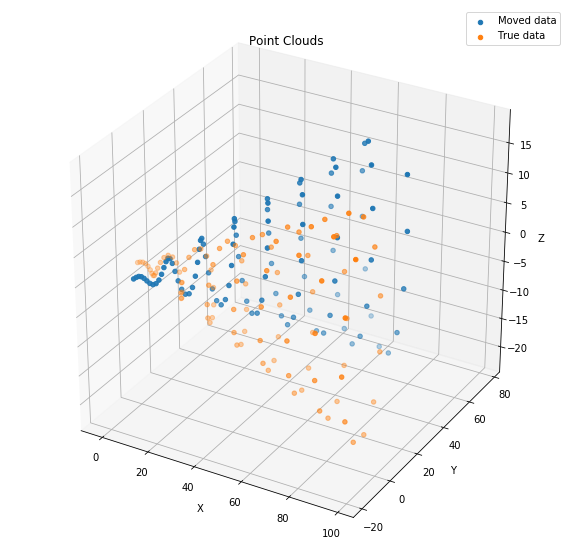

In [5]:
'''Generate data using the sin and cosine functions'''
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[cos(angle[2]), -sin(angle[2]), 0], 
                      [sin(angle[2]), cos(angle[2]), 0],
                      [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, -sin(angle[1])],
                      [0, 1, 0] ,
                      [sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), -sin(angle[0])],
                      [0, sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((3, numPoints))
    sourceData[0, :] = range(0, numPoints)
    sourceData[1, :] = 0.2 * sourceData[0, :] * np.sin(0.5 * sourceData[0, :]) 
    sourceData[2, :] = 0.2 * sourceData[0, :] * np.cos(0.5 * sourceData[0, :]) 
    
    movedData = R.dot(sourceData) + shift
    return sourceData, movedData

'''Assign data to point clouds P and Q''' 
angle = [0, 0, pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateSpiral(100, angle, shift)

plotData(P, Q, "Moved data", "True data")
plt.show()

### Centering Data

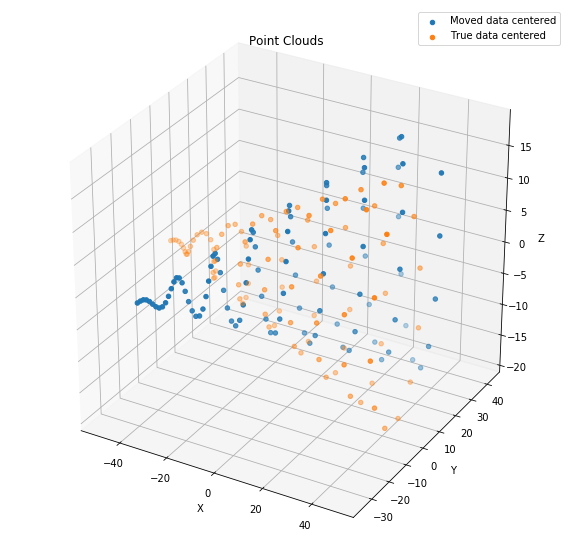

In [6]:
'''Function to center the source data and the moved data'''
def centerData(data, excludeIndices=[]):
    reducedData = np.delete(data, excludeIndices, axis = 1)
    center = np.array([reducedData.mean(axis = 1)]).T
    return center, data - center

centerP, Pcentered = centerData(P)
centerQ, Qcentered = centerData(Q)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')

### Identifying Corresponding Points 

In [7]:
'''For each point in the  moved data get closest points in the source data'''
def getCorrespondences(P, Q):
    pSize = P.shape[1]
    qSize = Q.shape[1]
    correspondences = []
    for i in range(pSize):
        pPoint = P[:, i]
        minDist = sys.maxsize
        chosenIndex = -1
        for j in range(qSize):
            qPoint = Q[:, j]
            dist = np.linalg.norm(qPoint - pPoint)
            if dist < minDist:
                minDist = dist
                chosenIndex = j
        correspondences.append((i, chosenIndex))
    return correspondences

'''Connect the obtained corresponding points using grey lines'''
def drawCorrespondences(P, Q, correspondences):
    labelAdded = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not labelAdded:
            plt.plot(x, y, z, color = 'grey', label = 'Correpondences')
            labelAdded = True
        else:
            plt.plot(x, y, z, color = 'grey')
    plt.legend()

### Plotting Corresponding Points

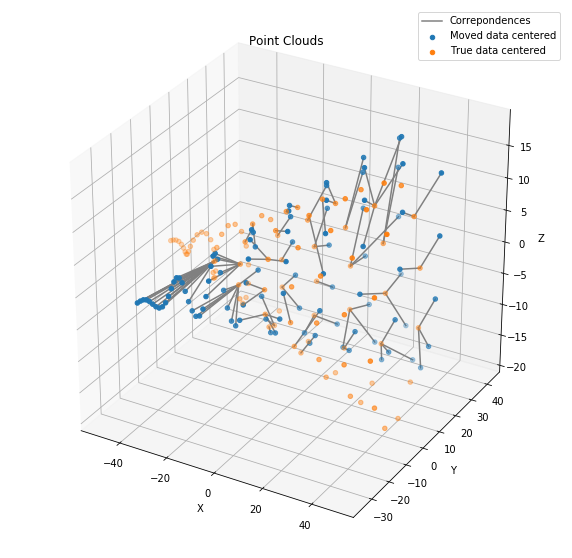

In [8]:
correspondences = getCorrespondences(Pcentered, Qcentered)
plotData(Pcentered, 
         Qcentered,
         'Moved data centered',
         'True data centered')
drawCorrespondences(Pcentered, Qcentered, correspondences)

### Computing Cross Covariance

In [9]:
'''Function to compute the covarianve between the moved data and the source data along the three axes'''
def computeCrosscovariance(P, Q, correspondences, kernel = lambda diff: 1.0):
    cov = np.zeros((3, 3))
    excludeIndices = []
    for i, j in correspondences:
        pPoint = P[:, [i]]
        qPoint = Q[:, [j]]
        weight = kernel(pPoint - qPoint)
        if weight < 0.01: excludeIndices.append(i)
        cov += weight * qPoint.dot(pPoint.T)
    return cov, excludeIndices

cov, excludedIndices = computeCrosscovariance(Pcentered, Qcentered, correspondences)
print(cov)

[[45521.71050752 38378.63040061  -472.18585876]
 [15437.83482468 16025.6692051   -171.79374759]
 [ -446.67633346  -461.31317938  4364.55578095]]


### SVD 
##### To get rotation matrix and translation vector

In [10]:
'''Taking SVD to obtain the rotation matrix and translation vector'''
U, S, VT = np.linalg.svd(cov)
print("Singular Values : \n", S)
Rfound = U.dot(VT)
tfound = centerQ - Rfound.dot(centerP)
print("R : \n", Rfound)
print("t : \n", tfound)

Singular Values : 
 [63532.27698281  4359.57258469  2156.9130949 ]
R : 
 [[ 0.93705024  0.34919199 -0.00134031]
 [-0.34916511  0.93701415  0.00939164]
 [ 0.00453537 -0.00833245  0.999955  ]]
t : 
 [[  6.20196303]
 [-21.27608015]
 [  3.13861204]]


### Correction
##### Corrections of the moved point cloud with one iteration of SVD

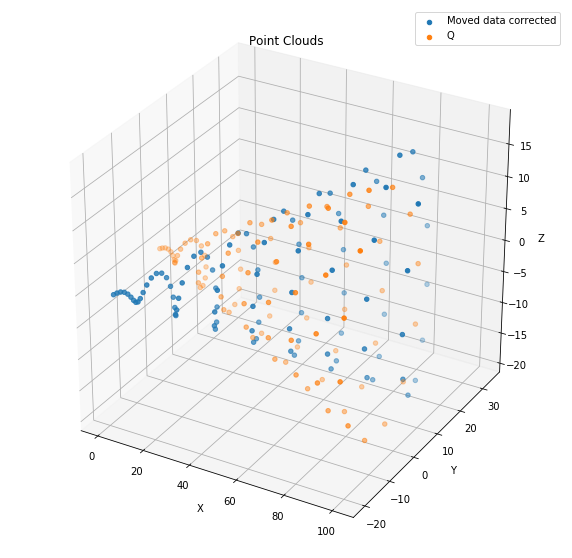

Squared difference (P Corrected - Q):  127.64162305282593


In [11]:
'''Correct the moved data using the obatined R and t'''
Pcorrected = Rfound.dot(P) + tfound
plotData(Pcorrected, Q, 'Moved data corrected', 'Q')
plt.show()
print("Squared difference (P Corrected - Q): ", np.linalg.norm(Pcorrected - Q))

### Iterative Point Cloud Using SVD

In [12]:
'''Iterations of ICP using SVD'''
def ICP(P, Q, iterations = 10, kernel=lambda diff: 1.0):
    centerQ, Qcentered = centerData(Q)
    normValues = []
    Pvalues = [P.copy()]
    Pcopy = P.copy()
    correspValues = []
    excludeIndices = []
    for i in tqdm( range(iterations), desc ="Iteration"):
        centerP, Pcentered = centerData(Pcopy, excludeIndices)
        correspondences = getCorrespondences(Pcentered, Qcentered)
        correspValues.append(correspondences)
        normValues.append(np.linalg.norm(Pcentered - Qcentered))
        cov, excludeIndices = computeCrosscovariance(Pcentered, Qcentered, correspondences, kernel)
        U, S, VT = np.linalg.svd(cov)
        R = U.dot(VT)  
        t = centerQ - R.dot(centerP)  
        Pcopy = R.dot(Pcopy) + t
        Pvalues.append(Pcopy)
    correspValues.append(correspValues[-1])
    return Pvalues, normValues, correspValues

### Results

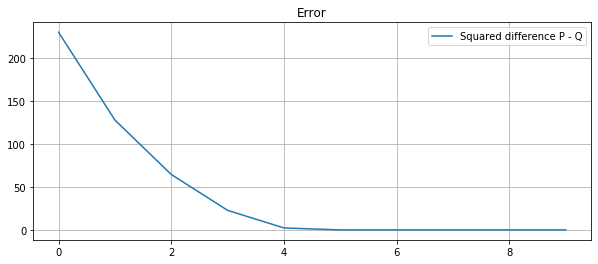

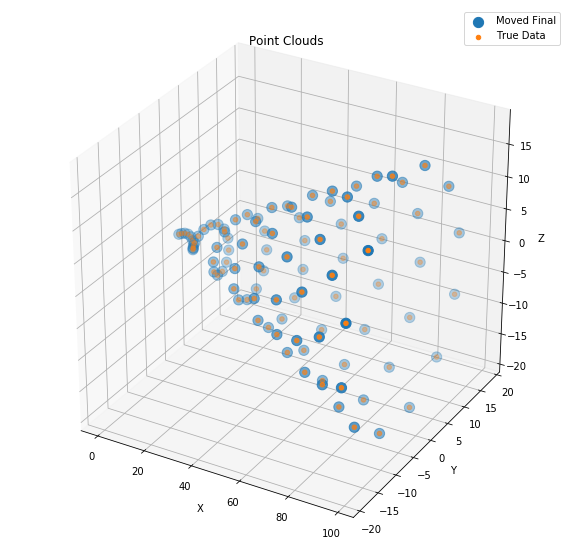

CPU times: user 1.29 s, sys: 161 ms, total: 1.46 s
Wall time: 1.11 s


In [13]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
plotData(Pvalues[-1], Q, 'Moved Final', 'True Data', markersize1 = 105)
plt.show()

### Ten Thousand Points 

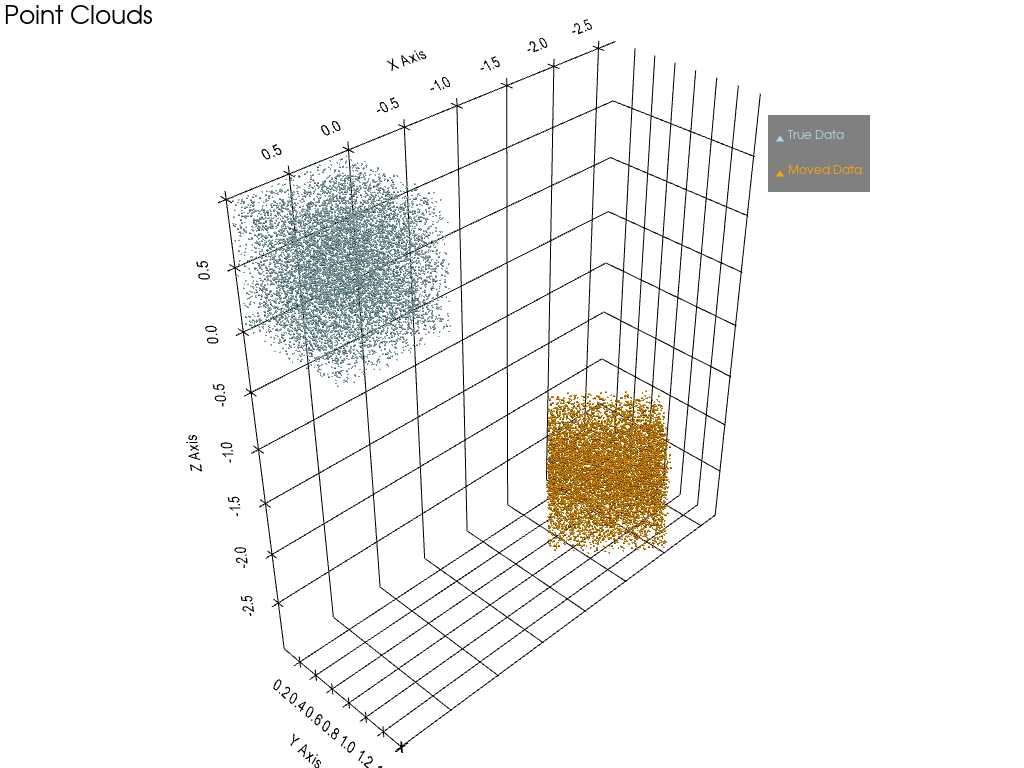

In [14]:
'''Assign data to point clouds P and Q''' 
angle = [0, 0, pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateData(10000, angle, shift)

bigPlot(P, Q, 2, 2)

In [ ]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)

### Ten lakh points

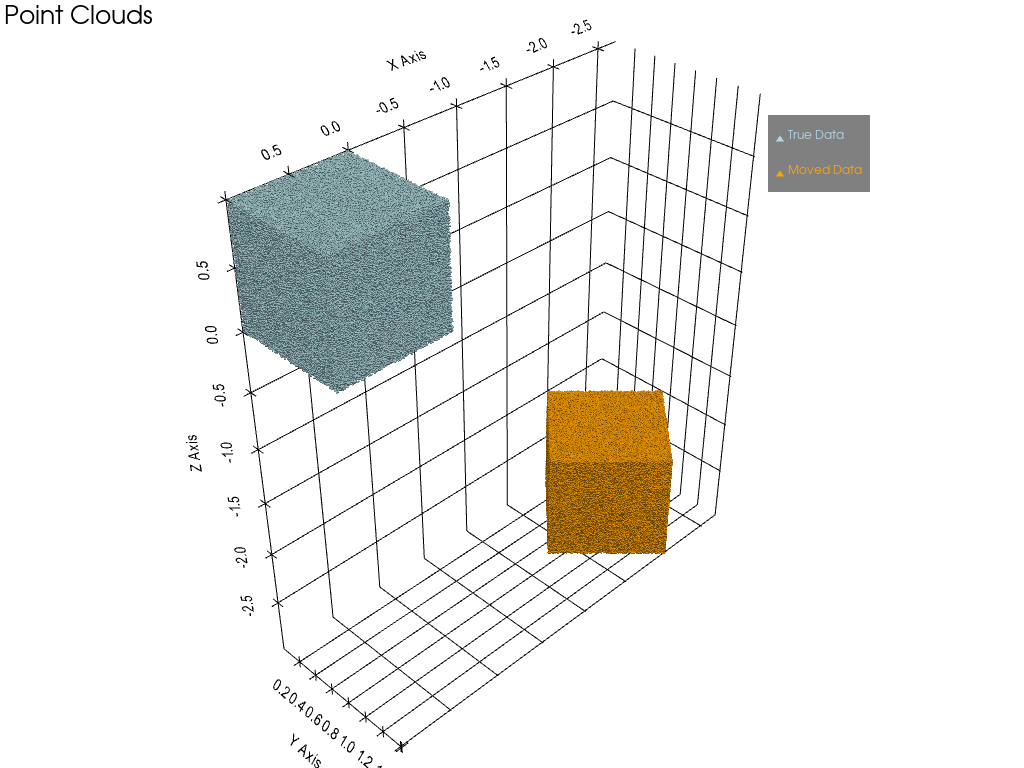

In [16]:
'''Assign data to point clouds P and Q''' 
angle = [0, 0, pi/4]
shift = np.array([[-2], [0], [-3]])
Q, P = generateData(1000000, angle, shift)

bigPlot(P, Q, 2, 2)

In [ ]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)

### Redwood Dataset

In [18]:
!pip install open3d
import open3d as o3d

In [19]:
rawColor = o3d.io.read_image("Dataset/00000.jpg")
rawDepth = o3d.io.read_image("Dataset/00000.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
         rgbdImage,
         o3d.camera.PinholeCameraIntrinsic(
         o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

P = np.array(np.asarray(pcd.points)).T

rawColor = o3d.io.read_image("Dataset/00004.jpg")
rawDepth = o3d.io.read_image("Dataset/00004.png")

rgbdImage = o3d.geometry.RGBDImage.create_from_color_and_depth(rawColor, rawDepth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbdImage,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

Q = np.array(np.asarray(pcd.points)).T
minPoints =  min(P.shape[1], Q.shape[1])
P, Q = P[:, :minPoints], Q[:, :minPoints]

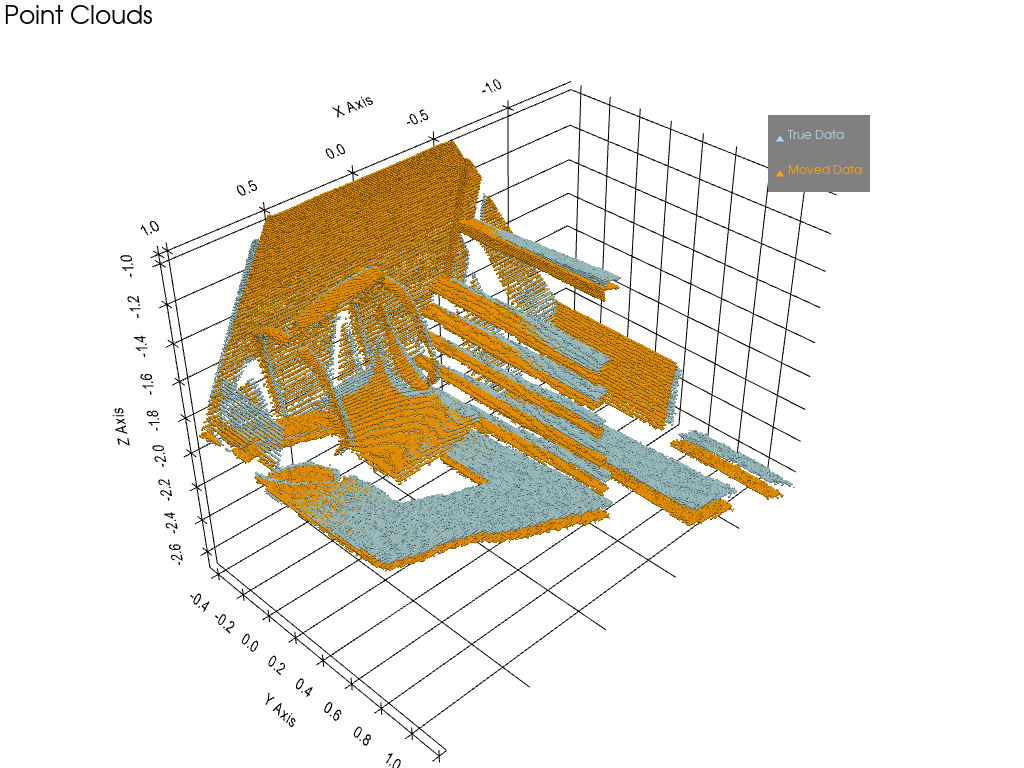

In [20]:
bigPlot(P, Q, 2, 2)

In [ ]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)

### My Room Dataset 

In [ ]:
sourceload = o3d.io.read_point_cloud("ply/roomOne.ply")
Q = np.asarray(sourceload.points).T

destinationload = o3d.io.read_point_cloud("ply/roomTwo.ply")
P = np.asarray(destinationload.points).T

In [ ]:
bigPlot(P, Q, 2, 2)

In [ ]:
%%time
Pvalues, normValues, correspValues = ICP(P, Q)
plotValues(normValues, "Squared difference P - Q")
bigPlot(Pvalues[-1], Q, 5, 5)